# BM 336027 - Technion - Medical Image Processing


## Homework 4 - Image restoration and quantization
---

### <a style='color:red'> Due Date: 11.1.2023 </a>

### Agenda

* [Exercise 1: Wiener filter](#Exercise-1)
* [Exercise 2: Max-Lloyd quantizer](#Exercise-2)


#### Use as many cells as you need

---
### Students Information

* Fill in


|              Name  |             Id  |             email |
|--------------------|-----------------|------------------ |
|    Michal Appel    |    206058216    | michal.appel@campus.technion.ac.il |

### Submission Guidelines
---
* **No handwritten submissions.** 
* What you have to submit:
    * You should submit this file only, with the name: `bm_hw4_id.ipynb`.
    * No other file-types (`.py`, `.docx`...) will be accepted.
* Submission on the course website (Moodle).
* **Please submit the notebook after running with the final results without error messages**

In [2]:
# imports you will need
import numpy as np
from numpy import fft
import matplotlib.pyplot as plt
from scipy.signal import convolve2d
from skimage.color import rgb2gray
from skimage.data import colorwheel
from typing import Tuple, List
%matplotlib inline

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
os.chdir("drive/My Drive/impr/hw4")

### **Assignment Instructions**
**In this assignment, you are allowed to use the imported functions, basic numpy its sub modules functions, matplotlib functions, and functions you implemented in other sections of the exercises (unless otherwise instructed)**

---


###  Exercise 1



In this exercise you will implement and use the Wiener filter to deblur and denoise an image.   

1. Load the image 'glasses.jpg' and the filter 'glasses_filter.npy'.   
Convert the image 'glasses.jpg' to gray scale.   
'.npy' files can be loaded using the np.load function.   
Show the original image and the image after being blurred by the given filter and adding noise to it so that its PSNR will be 100.


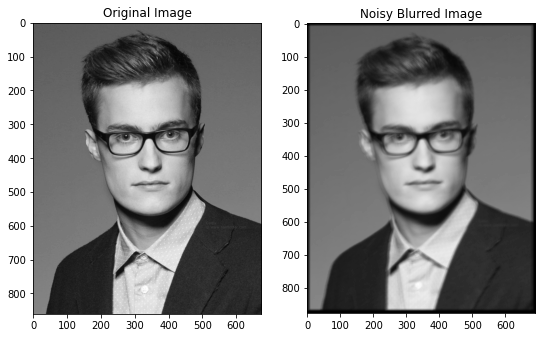

In [130]:
# ====== YOUR CODE: ======
# Load image and filter
org_img = plt.imread('data/glasses.jpg')
filter = np.load('data/glasses_filter.npy')

# Convert image to gray scale, apply filter and add noise
img_gs = rgb2gray(org_img)
img_filter = convolve2d(img_gs, filter)

pnsr = 100
sigma = np.abs(np.max(img_filter) / (10**(pnsr/20)))
noise = np.random.normal(0, sigma, img_filter.shape)
noisy_img = img_filter + noise

# Display the original image and the editted image
plt.figure(figsize=(9,9))
plt.subplot(121), plt.imshow(img_gs,'gray'), plt.title('Original Image')
plt.subplot(122), plt.imshow(noisy_img,'gray'), plt.title('Noisy Blurred Image')
plt.show()
# ========================

2. Implement the `wiener_filter` function that recieves a blurry and noisy image, a filter kernel and a prior array and returns the restored image.<br>
The prior array is the believed signal-to-noise ratio of the Fourier transforms of the original image $(I)$ and noise $(N)$. The prior array will be what we believe is the ratio $\frac{N}{I}$.<br>
Don't forget to set the s parameter in the fft function.

In [131]:
def wiener_filter(img: np.ndarray, kernel: np.ndarray, prior: np.ndarray) -> np.ndarray:
    '''
     This function gets blurry noisy image, a filter kernel and a prior array in
      the Fourier domain and returns the restored image.
    
    :param img: a blurry and noisy image
    :param kernel: a kernel matrix for bluring filter
    :param prior: the ratio between the noise and the image (N/I)
    :return img_restored: the restored image 
    '''
    # ====== YOUR CODE: ======
    # Fourier transform of inputs
    img_fft = np.fft.fft2(img)
    kernel_fft = np.fft.fft2(kernel, s=img.shape)

    # Weiner filtering
    wiener = np.conjugate(kernel_fft) / (np.abs(kernel_fft)**2 + np.abs(prior)**2)

    # returns the restored image
    img_restored = np.abs(np.fft.ifft2(wiener * img_fft))
    # ======================== 
    return img_restored

3. Use your `wiener_filter` function on the blurred and noisy image you created to restore it using the power law as a prior on the magnitude of the image in the Fourier domain. 
$$ \left|I(u, v)\right|=\frac{I_0}{\sqrt{u^2+v^2}} $$
$$ \left|N(u, v)\right|= N_0$$
Where $N_0$ is some constant that is dependent on the magnitude of the noise. 
And $I_0$ is a constant that is dependent on the magnitude of the image.
$u$ and $v$ are frequencies.
Your prior, therefore, will be $$ K_0\cdot\sqrt{u^2+v^2} $$
Show your results of using your implementation of the Wiener filter on the blurred and noisy image with two different value of $K_0$ (try to get resonable results).    
Compare those results to those you get when you use the same regulerization value for all frequencies (not dependent on $u$ and $v$). You may look for another regulerization constant.   
Show the noisy image and the images you get after your tries of restoration for each prior.


In [155]:
def get_prior(k0, u, v):
  prior[u,v] = k0*np.sqrt(u**2 + v**2)
  return prior

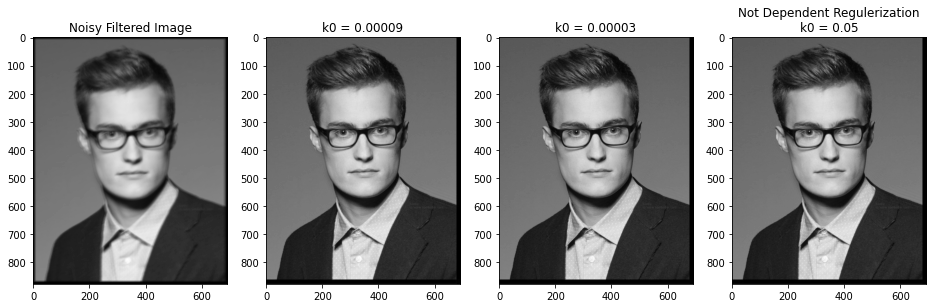

In [156]:
# ====== YOUR CODE: ======
k = [0.00009, 0.00003, 0.05]
titles = ['k0 = 0.00009', 'k0 = 0.00003']

prior = np.zeros_like(noisy_img)
u = np.arange(prior.shape[0])
v = np.arange(prior.shape[1])
U, V = np.meshgrid(u, v)

plt.figure(figsize=(16, 12))
plt.subplot(141),plt.imshow(noisy_img, 'gray'), plt.title('Noisy Filtered Image')

for i in range(2):
  prior = get_prior(k[i], U, V)
  res_img = wiener_filter(noisy_img, filter, prior)
  plt.subplot(1, 4, i+2), plt.imshow(res_img, cmap='gray'), plt.title(titles[i])
  
prior4 = k[2]*np.ones_like(noisy_img)
res_img = wiener_filter(noisy_img, filter, prior4)
plt.subplot(1, 4, 4), plt.imshow(res_img, cmap='gray'), plt.title('Not Dependent Regulerization\nk0 = 0.05')

plt.show()
# ========================

4. Repeat the last instructions for the image after being blurred by the given filter and having noise added to it such that its PSNR will be 10. 

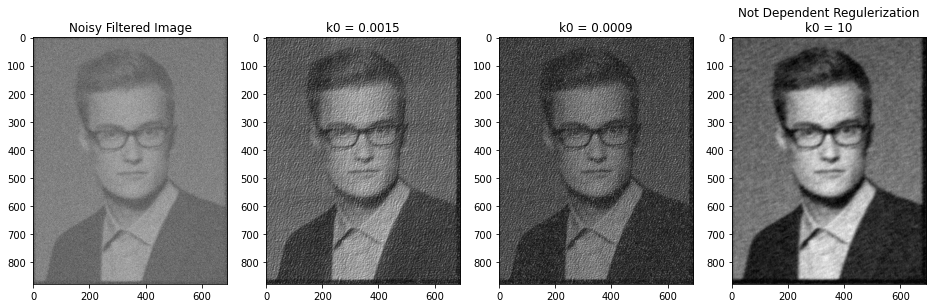

In [161]:
# ====== YOUR CODE: ======
wanted_pnsr = 10
i_max = np.max(img_filter)
std = np.abs(i_max/(10**(wanted_pnsr/20)))
noise = np.random.normal(0, std, img_filter.shape)
noisy_img10 = img_filter + noise

k = [0.0015, 0.0009, 10]
titles = ['k0 = 0.0015', 'k0 = 0.0009']

prior = np.zeros_like(noisy_img10)
u = np.arange(prior.shape[0])
v = np.arange(prior.shape[1])
U, V = np.meshgrid(u, v)

plt.figure(figsize=(16, 12))
plt.subplot(141),plt.imshow(noisy_img10, 'gray'), plt.title('Noisy Filtered Image')

for i in range(2):
  prior = get_prior(k[i], U, V)
  res_img = wiener_filter(noisy_img10, filter, prior)
  plt.subplot(1, 4, i+2), plt.imshow(res_img, cmap='gray'), plt.title(titles[i])
  
prior4 = k[2]*np.ones_like(noisy_img10)
res_img = wiener_filter(noisy_img10, filter, prior4)
plt.subplot(1, 4, 4), plt.imshow(res_img, cmap='gray'), plt.title('Not Dependent Regulerization\nk0 = 10')

plt.show()
# ========================

###  Exercise 2



In this exercise, you will Implement the Max-Lloyed algorithm for quantization of pixel values of an RGB image. 

Given a set of quantization levels $\left\{f_i^{(k)}\right\}$, we want to find a better set of quantization levels $\left\{f_i^{(k+1)}\right\}$. Finding and representing the borders of the quantization regions is hard in any dimension higher than 1D, therefore, instead of finding the decision levels, you will use the euclidean distance of each pixel value in the 3D RGB space for the quantization levels. A pixel value " belongs" to the quantization level closest to it. Next, find the new quantization levels by computing the mean pixel value belonging to each previous quantization level.      

1. Implement the function `max_lloyd_iter` that receives the image and a set of quantization levels and returns the next set of quantization levels. The quantization levels you are looking for are 3-dimensional vectors. Do not perform quantization for each color channel separately.  
Note: you can infer the dimension by assuming a 'channel last' convention. <br>
Write a description of your function and explain its inputs and output.   



In [167]:
def max_lloyd_iter(img: np.ndarray, prev_levels: np.ndarray) -> np.ndarray:
    '''
    This function gets an image and a set of quantization levels and returns
     the next set of quantization levels. 
        
    :param img: 3D numpy array of RGB image
    :param prev_levels: 2D numpy array of quantization levels f(k)
    :return new_levels: 2D numpy array of the next quantization levels f(k+1)
    '''
    # ====== YOUR CODE: ======
    M,N = img[:,:,0].shape
    level_idx = 0
    k = prev_levels.shape[0]
    temp = np.zeros_like(prev_levels)
    count = np.zeros(k)
    dist = float('inf')

    for row in range(M):
        for col in range(N):

            for i in range(k):
              dist_temp = np.linalg.norm(img[row,col]-prev_levels[i])
              if dist_temp < dist:
                dist = dist_temp
                level_idx = i

            temp[level_idx] += img[row,col]
            count[level_idx] += 1

    for j in range(k):
        if count[j] == 0:
            count[j] = 1
    new_levels = temp/count.T[:,None]
    # ========================   
    return new_levels

To perform quantization, you have to initialize the quantization levels to some guess and iteratively improve that initial guess. You stop improving your quantization levels when a criterion you chose is met.<br>

2. Implement the function `max_lloyd_quantize` that receives an image and a number of quantization levels, performs Max-Lloyd quantization and returns the quantization levels and your metric values at each iteration.
    To ensure your algorithm does not run too long (in cases your threshold is too low), use the 'max_iter' parameter to stop your function prematurely. <br>
    Initialize the first level with a random value in the RGB space; for this initialization, set the 'init_type' parameter to 'random_rgb'.<br>
    The input and output data types have to be uint8.<br>
    Write a description of your function and explain its inputs and output. 


In [168]:
def max_lloyd_quantize(img: np.ndarray, level_num: int, threshold: float, max_iter: int,
                       init_type: str) -> Tuple[np.ndarray, np.ndarray]:
    '''
      
    This function gets an image and a number of quantization levels, and returns
    the quantization levels and metric values at each iteration after performing
    Max-Lloyd quantization.
    
    :param img: 3D numpy array of RGB image
    :param level_num: number of quantization levels
    :param threshold: maximun threshold for MSE value
    :param max_iter: maximum number of iterations
    :param init_type: random value in the RGB space
    :return new_levels: 2D numpy array of the new quantization levels
    :return metric_vals: 1D numpy array of MSE's value of all iterations.
    '''
    # ====== YOUR CODE: ======
    if init_type == 'random_rgb':
      first_level = np.random.randint(0, 255, (level_num,3))
    elif init_type == 'random_img':
      first_level = init_levels(img,level_num)
        
    new_levels = []
    metric_vals = []
    iter_count = 0
    dist = threshold + 1

    while int(dist) > threshold and iter_count < max_iter:
        f_new = max_lloyd_iter(img, first_level)
        iter_count += 1
        dist = np.mean((f_new-first_level)**2)

        first_level = f_new
        new_levels.append(f_new.astype('uint8'))
        metric_vals.append(dist.astype('uint8'))

    new_levels = new_levels
    metric_vals = metric_vals
    # ======================== 

    return new_levels, metric_vals

Run the cell below:

In [163]:
np.random.seed(9)
image = np.random.randint(0, 233, (2, 2, 3))
quant_levels, metric = max_lloyd_quantize(image, 4, threshold = 0.1, max_iter = 20, init_type='random_rgb')
print(f'quantization level:\n{quant_levels} \n\n metric:{metric}')

quantization level:
[array([[  0,   0,   0],
       [153,  68,  84],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8), array([[  0,   0,   0],
       [153,  68,  84],
       [  0,   0,   0],
       [  0,   0,   0]], dtype=uint8)] 

 metric:[23, 0]


**3. Did you run into errors when trying to run the above cell? 
     What caused these errors?  
     How do you think you can solve the issue causing these errors to rise?**

**Answer:**

Yes, by running the cell above we get that some of the new quantization levels were reset so they're displayed as arrays of zeros. More over, the results wasn't improved during the iterations.
It happend since the function using the euclidean distance so some of the quantization levels did not acquire any pixel values (the image contains only four pixels) and these quantization levels were reset.
It can be solved by choosing the initiated levels to be values from out image.

4. Go back to your implementation of the function `max_lloyd_quantize` and add an initialization strategy that chooses random values from the image pixels (3D vectors) as initial quantization levels instead of choosing random points in the RGB space.  This time, set the 'init_type' parameter to 'random_img'. <br>
Implement the function `init_levels` that receives an image and a number of quantization levels (K) and returns a random choice of pixels vaules that can be used as initial quantization levels (a Kx3 array).<br>
Make sure you do not use the same pixel value twice. <br>
Write a description of your function and explain its inputs and output.<br>


In [183]:
def init_levels(img: np.ndarray, level_num: int) -> np.ndarray:
    '''
    This function gets an image and a number of quantization levels and returns
     a random choice of pixels vaules for using as initial quantization levels.
    
    :param img: an image
    :param level_num: number of quantization levels (K)
    :return init_vals: random pixels values for the initial quantization levels
     (kX3)
    '''
    # ====== YOUR CODE: ======
    img_values = np.unique(img.reshape(-1, img.shape[2]), axis=0)
    img_idx = np.zeros(len(img_values))
    init_vals = np.zeros((level_num,3))
    
    for i in range(level_num):
        rnd = np.random.randint(0, len(img_values))
        while(img_idx[rnd] != 0):
            rnd = np.random.randint(0, len(img_values))
        img_idx[rnd] += 1
        init_vals[i] = img_values[rnd]
    # ========================    
    return init_vals

**5. Why is it important to make sure you do not use the same quantization level twice? what will happen if you do use the same quantization level twice?**

**Answer:**

It is important to make sure we don't use the same quantization level twice. 
If we use the same quantization level twice, we will have two levels with the same value. Thus, the number of quantization levels will be lower than it should. As a result, we will not get an image with the required number of quantization levels.

6. Implement the function `img_quantize` that receives an image and quantization levels and creates a quantized version of the image.<br> 
Write a description of your function and explain its inputs and output.<br>


In [184]:
def img_quantize(img: np.ndarray, quant_levels: np.ndarray,) -> np.ndarray:
    '''
    This function gets an image and quantization levels and returns a quantized
     version of the image.
    
    :param img: 3D numpy array of RGB color image
    :param qunt_levels: 2D numpy array of the quantization levels
    :return qunt_img: 3D numpy array of the quantized version of the image
    '''
    # ====== YOUR CODE: ======
    M,N = img[:,:,0].shape
    quant_img = np.zeros(img.shape)
    lvl = 0
    dist = float('inf')
    k = quant_levels.shape[0]

    for row in range(M):
        for col in range(N):

            for i in range(k):
              dist_temp = np.linalg.norm(img[row,col]-quant_levels[i])
              if dist_temp < dist:
                dist = dist_temp
                lvl = i
                
            quant_img[row,col] = quant_levels[lvl]
    quant_img = quant_img.astype('uint8')
    
    # ========================  
    return quant_img

7.  Use your function on the images 'colorwheel'.   
Show the original image and its quantized versions (4, 8, 16, and 32 colors) alongside the progression of their metric. Please include in the metrics plots the threshold as a line parallel to the iterations' axis along with the progression of the metric. Add titles to your plots. 

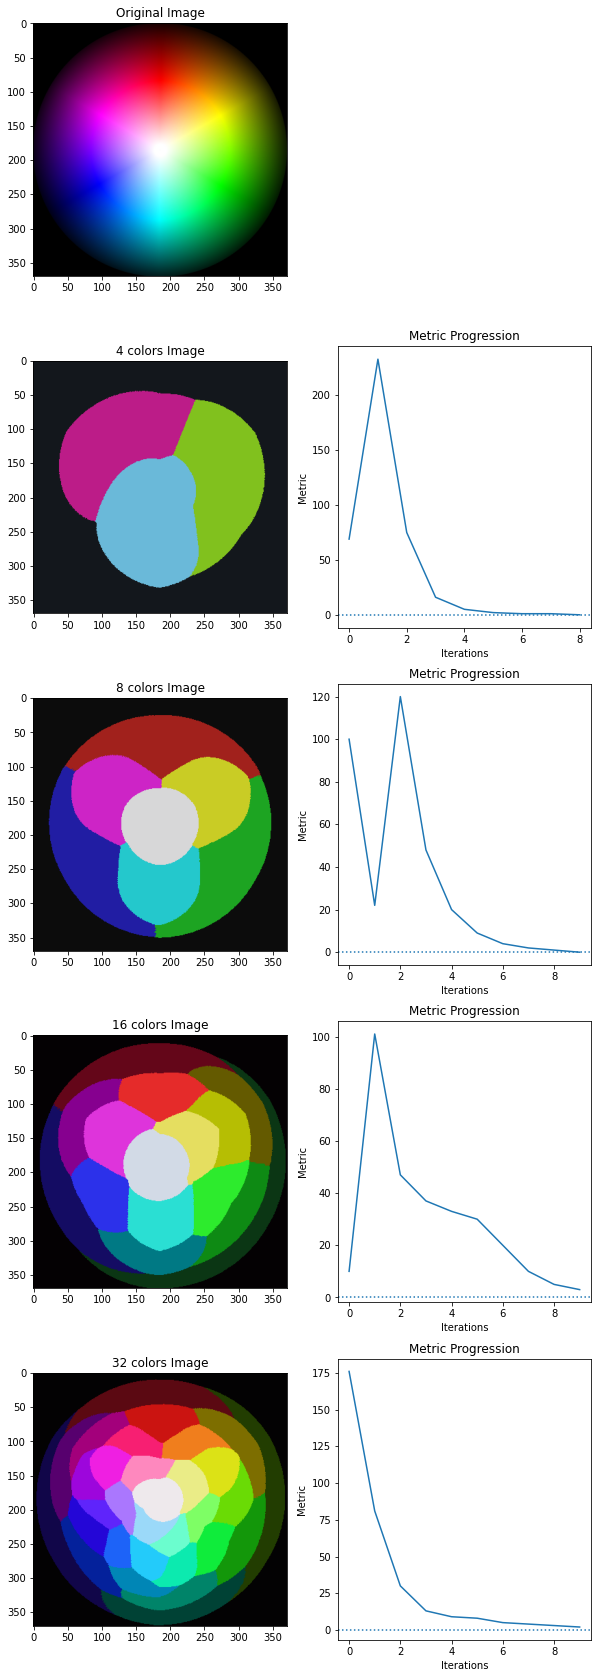

In [185]:
cw_img = colorwheel()
th = 0.1
max_iter = 10
quan_val = [4, 8, 16, 32]
i = 3

plt.figure(figsize=(10,30))
plt.subplot(521), plt.imshow(cw_img), plt.title('Original Image')

for val in quan_val:
    cw_levels, cw_metrics = max_lloyd_quantize(cw_img, val, th, max_iter, init_type='random_img')
    cw_quan = img_quantize(cw_img, cw_levels[-1])
    plt.subplot(5,2,i)
    plt.imshow(cw_quan)
    plt.title(f'{val} Colors Image')

    plt.subplot(5,2,i+1), plt.plot(cw_metrics)
    plt.axhline(th, linestyle = ':')
    plt.title(f'Metric Progression')
    plt.xlabel('Iterations')
    plt.ylabel('Metric')

    i = i+2
plt.show()

8. Use your function on the the image 'gray_lena.jpg' before and after adding random Gaussian noise with a std of half the difference between the quantization levels to it.
Show the original clean image along with its quantized version (2 colors) and the quantized version of the noisy image.   
Add titles to your plots.   


(<matplotlib.axes._subplots.AxesSubplot at 0x7fdaffb03280>,
 Text(0.5, 1.0, 'Quantized images'))

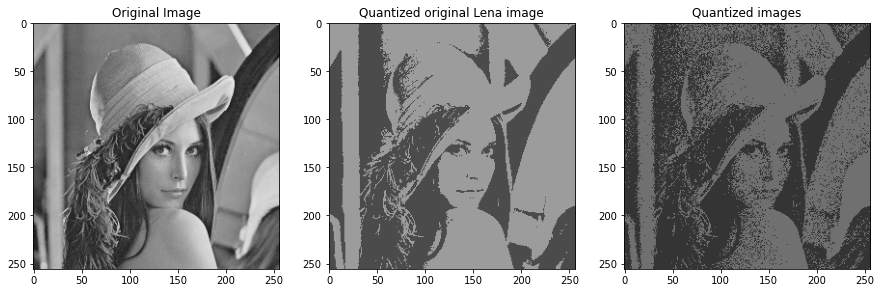

In [176]:
# ====== YOUR CODE: ======
lena_img = plt.imread('data/gray_lena.jpg')
k = 2
th = 0.1
max_iter = 10

plt.figure(figsize=(12, 12))

# Original clean image
lena_levels, metric  = max_lloyd_quantize(lena_img, k, th, max_iter, init_type='random_img')
plt.subplot(131), plt.imshow(lena_img), plt.title('Original Image')

# Quantized version
quan_img = img_quantize(lena_img, lena_levels[-1])
plt.subplot(132), plt.imshow(quan_img), plt.title('Quantized Original Image')

# Quantized version of the noisy image
std = abs(0.5 * (lena_levels[-1][1][0].astype('int64')-lena_levels[-1][0][0].astype('int64')))
noise = np.random.normal(0, std, lena_img.shape) 
noisy_img = lena_img + noise
lena_levels_noisy, metric_noisy = max_lloyd_quantize(noisy_img, k, th, max_iter, init_type='random_img')
quan_noisy_img = img_quantize(noisy_img, lena_levels_noisy[-1])
plt.subplot(133), plt.imshow(quan_noisy_img), plt.title('Quantized Images')
# ========================

**9. Which of the images looks better to you? Comment on the egde preservation and the number of perceived colors.**

**Answer:**

the quantized image with the noise looks better to me, because the edges are preserved better. In contrast to the quantized image which is more clean. 
Since we have only two colors the combination between them creates a noise structure, and removes the edges.